### Package Imports

In [294]:
# Explainability
#!pip install -r requirements.txt --user
#!pip install tensorflow==1.13.1
#!pip install shap==0.28.5
#!pip install plotly

#!pip install cufflinks
#!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import shap
from utils.helpful_util import ExplainShap
from matplotlib import rcParams
import os
from IPython.display import display_html
from IPython.display import display, HTML
from gam.gam.gam import GAM 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
from utils.helpful_util import display_abs_shapvalues, display_shapvalues
import seaborn as sns
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import cufflinks as cf
import matplotlib.pyplot as plt
from utils.helpful_util import plot_confusion_matrix
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report
import sklearn
import lime.lime_tabular
import lime
import keras
import pandas as pd
import numpy as np
import matplotlib
from utils.helpful_util import display_sklearn_feature_importance, Perturb
from utils.load_objects import save_obj, load_obj, load_models_lendingclub
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
#tf.reset_default_graph()

display(HTML("<style>.container { width:75% !important; }</style>"))


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Load functions & Data Objects stored locally

In [31]:
# Loading COO Matrices - sparse with OHE of all original Features
# Load UDFs to use later.


# Keras and Sklearn have different ways of showing prediction probabilities. Keras == model.predict, sklearn == model.predict_proba
def explain_lime(model, train, test, observation, seed=1, num_features=10):
    '''
    Parameters:
        model: object,
            Random Forest: rfc
            Gradient Boosted Classifier: gbc
            Logistic Regression: logit
            Keras Neural Network = keras_ann
            Sklearn Neural Network = sk_ann
        train: object; train set dataframe
        test: object; test set dataframe
        observation: int (index of explanation on test data set)
        seed: int; default to 1
        num_features: int, the number of features to be displayed in explanation

    Returns:
        Local explanations over test set - Summary
    '''
    np.random.seed(seed)
    i = observation

    if type(model) == keras.engine.sequential.Sequential:
        def predict_fn(x): return model.predict(encoder.transform(x).toarray())
    else:
        def predict_fn(x): return model.predict_proba(
            encoder.transform(x)).astype(float)

    explainer = lime.lime_tabular.LimeTabularExplainer(
        train,
        feature_names=feature_names,
        class_names=class_names,
        categorical_features=categorical_features,
        categorical_names=categorical_names,
        kernel_width=3)

    exp = explainer.explain_instance(
        test[i], predict_fn, num_features=num_features)
    exp.show_in_notebook(show_all=True)

    print('-' * 125)
    print('Model: {}'.format(models[str(type(model))][0]))
    print("Looking at Observation: {}".format(i))
    print("Actual Class Label: {}".format(y_test[i]))
    %matplotlib inline
    try:  # If Keras
        print("Predicted Class Label: {}".format(
            np.argmax(model.predict(encoder.transform(test).toarray()), axis=1)[i]))
        print("Prediction Confidence (Prob): {0:.2f}%".format(
            np.max(model.predict(encoder.transform(test).toarray())[i]*100)))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction......")
    except:  # If Sklearn
        print("Predicted Class Label: {}".format(np.argmax(model.predict_proba(encoder.transform(test[i].reshape(1, -1))).astype(float))
                                                 ))
        print("Prediction Confidence (Prob): {0:.2f}%".format(
            np.max(model.predict_proba(encoder.transform(test[i].reshape(1, -1)))[0])*100))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction: Top {} Features......".format(
            num_features))
    fig = exp.as_pyplot_figure()


# Load Data Objects. Stored these locally/remotely to avoid dependency issues
# list of all features used
feature_names = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'title', 'inq_last_6mths',
    'revol_bal', 'total_pymnt', 'total_rec_late_fee', 'last_pymnt_amnt',
    'acc_open_past_24mths', 'delinq_amnt', 'tax_liens', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
    'loan_condition'
]

# List only Continuous Feats.
continuous = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'inq_last_6mths',
    'revol_bal', 'total_pymnt', 'total_rec_late_fee', 'last_pymnt_amnt',
    'acc_open_past_24mths', 'delinq_amnt', 'tax_liens', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'
]

# Load Models
rfc, gbc, logit, keras_ann, sk_ann = load_models_lendingclub()

# indices of cat features
categorical_features = [1, 4, 5, 6, 7, 9]  # Get Nominal / Ordinal / etc..

# Load Dictionary of categorical features after encoded. Need this for Lime
categorical_names = load_obj('data_objects/categorical_names')

# all features as a list. Unwrapping encoding
features = []
for k in categorical_names.values():
    for i in k:
        features.append(i)

# Clean up Feats
features[:2] = ['Term:' + i for i in features[:2]]
features[2:9] = ['Loan_Grade:' + i for i in features[2:9]]
features[9:44] = ['Loan_SubGrade:' + i for i in features[9:44]]
features[44:56] = ['Employment_Length:' + i for i in features[44:56]]
features[56:60] = ['Home_Ownership:' + i for i in features[56:60]]
features[60:] = ['Loan_Title:' + i for i in features[60:]]
# Concatenate encoded features + continuous features
features = features + continuous

# Load necessary data objects. Pre encoded Data
X_train = load_obj('data_objects/X_train')
X_test = load_obj('data_objects/X_test')
y_train = load_obj('data_objects/y_train')
y_test = load_obj('data_objects/y_test')

# Load encoded data that models were trained on.
encoded_train = load_obj('data_objects/encoded_train')
encoded_test = load_obj('data_objects/encoded_test')

data = load_obj('data_objects/data')
encoder = load_obj('data_objects/encoder')

# Split
# Manual perturbations

# Generate a sample of the test set for feature perturbance
X_test_holdout = load_obj('data_objects/X_test')
idx = np.random.choice(X_test_holdout.shape[0], 2000,
                       replace=False)  # Random 2000 samples w/o replacements
X_test_holdout = X_test_holdout[idx]  # extract
X_test_holdout = pd.DataFrame(
    encoder.transform(X_test_holdout).toarray(),
    columns=features)  # Convert to DF for column names\
y_test_holdout = y_test[idx]

X_train_shap = pd.DataFrame(encoded_train.toarray(), columns=features)
X_test_shap = pd.DataFrame(encoder.transform(X_test).toarray(),
                           columns=features)

shap_values = load_obj('data_objects/shap_values')  # Load Dict of Shap Values

models = {
    str(type(rfc)): ('Random Forest', shap_values[str(type(rfc))]),
    str(type(gbc)):
    ('Gradient Boosted Classifier', shap_values[str(type(gbc))]),
    str(type(logit)): ('Logistic Regression', shap_values[str(type(logit))]),
    str(type(sk_ann)):
    ('Sklearn MultiLayer Perceptron', shap_values[str(type(sk_ann))]),
    str(type(keras_ann)):
    ('Keras Multilayer Perceptron', shap_values[str(type(keras_ann))])
}


model_dict_2 = {
    'keras neural network': keras_ann,
    'logistic regression': logit,
    'random forest': rfc,
    'gradient boosted trees': gbc,
    'sklearn neural network': sk_ann
}

models_widg = widgets.ToggleButtons(
    options=[
        'keras neural network', 'logistic regression',
        'gradient boosted trees', 'random forest', 'sklearn neural network'
    ],
    description='Models:',
    disabled=False,
    button_style='',
    tooltips=[
                'keras sequential neural network', 'sklearn logit',
                'sklearn gradient boosted classifier', 'sklearn random forest', 'sklearn neural network'
    ])

button_widg = widgets.Checkbox(
    value=False,
    description='Check me to save image',
    disabled=False
)


### Some statistics on our models

In [32]:
# Some classification Reports and Confusion Matrices
class_names = ['Bad Loan', 'Good Loan']

# Get Best accuracy scores


def get_best_score(x, y): return sklearn.metrics.accuracy_score(
    x, y.predict(encoded_test))


# Getting test score accuracy + printing
#rf_best_score = get_best_score(y_test, rfc)
#gbc_best_score = get_best_score(y_test, gbc)
#lr_best_score = get_best_score(y_test, logit)
#nn_best_score = get_best_score(y_test, sk_ann)
ker_nn_best_score = sklearn.metrics.accuracy_score(
    y_test, keras_ann.predict_classes(encoded_test.toarray()))

print("\033[1mPrinting Test Accuracy.... \033[0m")
print("Random Forest: {0:.2f} %".format(get_best_score(y_test, rfc) * 100))
print("Gradient Boosting: {0:.2f} %".format(get_best_score(y_test, gbc) * 100))
print("Logistic Regression: {0:.2f} %".format(
    get_best_score(y_test, logit) * 100))
print("SKLEARN Neural Net: {0:.2f} %".format(
    get_best_score(y_test, sk_ann) * 100))
print("Keras Neural Net: {0:.2f} % \n \n".format(ker_nn_best_score * 100))


Printing Test Accuracy.... 
Random Forest: 90.00 %
Gradient Boosting: 94.12 %
Logistic Regression: 88.40 %
SKLEARN Neural Net: 83.05 %
Keras Neural Net: 87.72 % 
 



In [33]:
'''
Cleaned up Code here. Added Drop Down to select the model to plot/print classification reports
Toggle Model for class report by different models

'''
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def print_class_report(x, y):
    return print(classification_report(x, y))


rcParams.update({'figure.autolayout': True})


@interact
def classif_reports(model=widgets.ToggleButtons(
        options=[rfc, logit, gbc, sk_ann, keras_ann])):
    print("\n\033[1m {} Classification Report...\n \033[0m".format(models[str(
        type(model))][0]))
    if model == keras_ann:
        cm = confusion_matrix(
            y_test, np.argmax(model.predict(encoded_test.toarray()), axis=1))
        print_class_report(
            y_test, np.argmax(model.predict(encoded_test.toarray()), axis=1))
    else:
        cm = confusion_matrix(y_test, model.predict(encoded_test))
        print_class_report(y_test, model.predict(encoded_test))
    plot_confusion_matrix(cm, classes=class_names, normalize=True)

interactive(children=(ToggleButtons(description='model', options=(RandomForestClassifier(bootstrap=True, class…

In [34]:
print("\tInteractive Correlation Mapping")


@interact
def correlations_int(
        column1=list(X_train_shap.select_dtypes('number').columns),
        column2=list(X_train_shap.select_dtypes('number').columns)):
    print(
        f"Correlation: {X_train_shap[column1].corr(X_train_shap[column2])}\n\n")


	Interactive Correlation Mapping


interactive(children=(Dropdown(description='column1', options=('Term: 36 months', 'Term: 60 months', 'Loan_Gra…

### Graphs Showing Standard Feature Importance via Sklearn API


In [35]:
# SciKit Learn Feature Importance in Linear Coefficient Rankinks
rcParams['figure.figsize'] = 5, 5  # Adjust plot size
'''
Logistic Regression Feature importance values are shown as the maximum potential coefficient values based on the max value of
the feature in question * the weight. 
I have the raw coeff. printed in tables side by side in a block below.

Toggle Feature Count to display more / less

'''


@interact
def sklearn_feature_importance_int(feature_count=widgets.Dropdown(options=list(
        range(1, encoded_train.shape[1])), value=10)):
    display_sklearn_feature_importance(data=encoded_train,
                                       set='lending',
                                       features=features,
                                       n_features=feature_count)


interactive(children=(Dropdown(description='feature_count', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1…

In [36]:
#Fetching logit coefficients and storing locally @ obj/lendingclub/logit_coefficients.csv
# + Generating standard errors

logistic_regress_coeff = pd.DataFrame({
    "features": features,
    "Coef": logit.coef_[0]
})
#logistic_regress_coeff.to_csv('obj/lendingclub/logit_coefficients.csv')

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'),
                 raw=True)


neg_coef = round(logistic_regress_coeff[
    logistic_regress_coeff['Coef'] < 0].sort_values('Coef', ascending=True),2)
pos_coef = round(logistic_regress_coeff[
    logistic_regress_coeff['Coef'] > 0].sort_values('Coef', ascending=False),2)
'''
Displaying Logit Coefficients.
Side by Side view. Left DF is negative coef, sorted by most negative first. Right is pos coefficient, sorted by most pos first
Coeff of 0 are excluded
'''

display_side_by_side(neg_coef, pos_coef)


,features,Coef
8,Loan_Grade:G,-108.09
7,Loan_Grade:F,-106.94
6,Loan_Grade:E,-69.69
5,Loan_Grade:D,-39.35
0,Term: 36 months,-28.63
1,Term: 60 months,-28.44
28,Loan_SubGrade:D5,-19.58
33,Loan_SubGrade:E5,-16.42
4,Loan_Grade:C,-14.36
23,Loan_SubGrade:C5,-13.57


### Exploring with Manual Feature Perturbation

###### Categorical Testing

In [37]:
'''#V1

import collections
scores_dict = {}

b = [(i / 100) for i in range(0, 101) if i %5 == 0]
scores_dict1_logit = {}


models = [logit, rfc, gbc, sk_ann, keras_ann]
model_str = ['logit', 'rfc', 'gbc', 'sk_ann', 'keras_ann']

col = 'Loan_Grade:A'
cols = [i for i in X_test_holdout.columns if 'Loan_Title' in i]

for m,n in zip(models, model_str):
    cols = [x for x in cols if x != col]
    scores_dict = {}
    for i in b:
        test = X_test_holdout.copy()
        scores = []
        counter = 0
        while counter < 25:
            idx = test.index[test[col] == 0].tolist()
            idx = np.random.choice(idx, int(len(idx) *i))
            test[col].iloc[idx,] = 1
            test[cols].iloc[idx,] = 0
            try:
                scores.append(collections.Counter(m.predict(test))[1])
            except:
                scores.append(collections.Counter(m.predict_classes(test))[1])
            counter +=1
            test = X_test_holdout.copy()
        scores_dict[i] = scores
    scores_dict1_logit[n] = scores_dict
    
test_dict_df = pd.DataFrame()
for i in scores_dict1_logit.keys():
    test_dict_df[i] = pd.DataFrame(scores_dict1_logit[i]).mean().values
test_dict_df = test_dict_df.T
#test_dict_df = test_dict_df / 2000
test_dict_df.columns = b
test_dict_df.to_csv('cat_pert1.csv')

'''

"#V1\n\nimport collections\nscores_dict = {}\n\nb = [(i / 100) for i in range(0, 101) if i %5 == 0]\nscores_dict1_logit = {}\n\n\nmodels = [logit, rfc, gbc, sk_ann, keras_ann]\nmodel_str = ['logit', 'rfc', 'gbc', 'sk_ann', 'keras_ann']\n\ncol = 'Loan_Grade:A'\ncols = [i for i in X_test_holdout.columns if 'Loan_Title' in i]\n\nfor m,n in zip(models, model_str):\n    cols = [x for x in cols if x != col]\n    scores_dict = {}\n    for i in b:\n        test = X_test_holdout.copy()\n        scores = []\n        counter = 0\n        while counter < 25:\n            idx = test.index[test[col] == 0].tolist()\n            idx = np.random.choice(idx, int(len(idx) *i))\n            test[col].iloc[idx,] = 1\n            test[cols].iloc[idx,] = 0\n            try:\n                scores.append(collections.Counter(m.predict(test))[1])\n            except:\n                scores.append(collections.Counter(m.predict_classes(test))[1])\n            counter +=1\n            test = X_test_holdout.copy(

In [292]:
#V2
'''
scores_dict = {}

b = [(i / 100) for i in range(0, 101) if i %5 == 0]
scores_dict1_logit = {}


models = [logit, rfc, gbc, sk_ann, keras_ann]
model_str = ['logit', 'rfc', 'gbc', 'sk_ann', 'keras_ann']

col = 'Loan_Grade:A'
cols = [i for i in X_test_holdout.columns if 'Loan_Grade' in i]

for m,n in zip(models, model_str):
    cols = [x for x in cols if x != col]
    scores_dict = {}
    print("Model: {}".format(n))
    for i in b:
        print("Sampling {}".format(i))
        test = X_test_holdout.copy()
        scores = []
        counter = 0
        while counter < 25:
            idx_0s = test.index[test[col] == 0].tolist() #find all 0 indices
            idx_1s = test.index[test[col] == 1].tolist() #find all 1 indices
            print("\tNumber of 1s after: {}".format(len(idx_1s)))

            idx = np.random.choice(idx_1s, int(len(idx_1s) *i), replace = False)#random select n indices from 0 indices
            print("\tNumber of 0 -> 1 : {}".format(idx.shape[0]))
            test[col].iloc[idx,] = 1 #change n indices from 0 to 1
            test[cols].iloc[idx,] = 0 #change n indices from 1 to 0
            try:
                scores.append(collections.Counter(m.predict(test))[1])
            except:
                scores.append(collections.Counter(m.predict_classes(test))[1])
            counter +=1
            test = X_test_holdout.copy()
        scores_dict[i] = scores
    scores_dict1_logit[n] = scores_dict
    
'''

'\nscores_dict = {}\n\nb = [(i / 100) for i in range(0, 101) if i %5 == 0]\nscores_dict1_logit = {}\n\n\nmodels = [logit, rfc, gbc, sk_ann, keras_ann]\nmodel_str = [\'logit\', \'rfc\', \'gbc\', \'sk_ann\', \'keras_ann\']\n\ncol = \'Loan_Grade:A\'\ncols = [i for i in X_test_holdout.columns if \'Loan_Grade\' in i]\n\nfor m,n in zip(models, model_str):\n    cols = [x for x in cols if x != col]\n    scores_dict = {}\n    print("Model: {}".format(n))\n    for i in b:\n        print("Sampling {}".format(i))\n        test = X_test_holdout.copy()\n        scores = []\n        counter = 0\n        while counter < 25:\n            idx_0s = test.index[test[col] == 0].tolist() #find all 0 indices\n            idx_1s = test.index[test[col] == 1].tolist() #find all 1 indices\n            print("\tNumber of 1s after: {}".format(len(idx_1s)))\n\n            idx = np.random.choice(idx_1s, int(len(idx_1s) *i), replace = False)#random select n indices from 0 indices\n            print("\tNumber of 0 -> 1

###### Continuous Testing

In [38]:
# Manually perturbing features to see impact on model output
p = Perturb(X=X_test_holdout, y=y_test_holdout,
            data_str='lending')  # Instantiation. Leave alone
'''
Can only perturb continuous feats atm.
Added interactive toggles. Select the feature and the amount you want to perturb by & see model impact
'''


@interact
def manual_perturb_int(feature=list(X_test_holdout[continuous].columns),
                       multiplier=1.0):
    p.manual_perturb(column=feature, scalar=multiplier)

interactive(children=(Dropdown(description='feature', options=('loan_amnt', 'int_rate', 'installment', 'annual…

In [39]:
#Heatmaps that show the same thing as the below graphs
@interact
def pert_heatmap(models=widgets.ToggleButtons(options=[
        'Random Forest', 'Gradient Boosted Classifier', 'Logistic Regression',
        'Sklearn Neural Network', 'Keras Neural Network'
]),
                 mode=widgets.RadioButtons(options=['Accuracy', 'Proportion']),
                 save=button_widg):
    if 'Accuracy' in mode:
        pert_dict = load_obj('perturbation_dict_accuracy')
    else:
        pert_dict = load_obj('perturbation_dict_proportion')
    temp1 = pd.DataFrame(pert_dict[models],
                         index=[(i / 100) for i in range(50, 151)
                                if i % 10 == 0]).T
    rcParams['figure.figsize'] = 7, 7
    sns.heatmap(temp1)
    plt.xlabel('Perturbation Amount')
    plt.ylabel('Feature')
    plt.title('{} heatmap: {} Against Feature Perturbation'.format(models, mode))
    if save:
        path = 'images/perturbation_heatmaps/{}_{}.png'.format(models, mode)
        plt.savefig(path)
        print("Image saved to {}".format(path))

interactive(children=(ToggleButtons(description='models', options=('Random Forest', 'Gradient Boosted Classifi…

In [11]:
#Showing Samples
'''
perturbation graphs. 
Two modes: Accuracy & proportion.
    'accuracy' shows the percentage of correct predictions on the holdout set as we iterate through a range of perturbations,
    with a perturbation of 1 = no perturbation at all (scalar multiple of 1 of specified colmns).
    'proportion' shows the percentage of observations classified as being of class 1 as we iterate through perturbations.
    
model: logit / rfc / gbc 
'''


@interact
def perturb_graph_int(
        models=widgets.ToggleButtons(options=[rfc, logit, gbc, keras_ann, sk_ann]),
        mode=widgets.RadioButtons(options=['accuracy', 'proportion']),
        feature=list(X_test_holdout[continuous].columns), save = button_widg):
    p.perturb_graph_int(model=models, mode=mode, column=feature)
    if save:
        path = 'images/perturbation_graphs/{}_{}.png'.format(mode, feature)
        plt.savefig(path)
        print("Image saved to {}".format(path))

'''
perturbation graphs continued.
This shows the same view as above, except displays all models simulataneously.

Two modes: Accuracy & proportion.
    'accuracy' shows the percentage of correct predictions on the holdout set as we iterate through a range of perturbations,
    with a perturbation of 1 = no perturbation at all (scalar multiple of 1 of specified colmns).
    'proportion' shows the percentage of observations classified as being of class 1 as we iterate through perturbations.
    

use toggle to mode and feature in question

added an html rendered dataframe that shows the raw values of the chart.
The y axis is the percent perturbed, or multiplier.
the cell body is the accuracy or proportion percentiles, as you'd see in the graph
'''


@interact
def perturb_graph_cons_int(
        mode=widgets.RadioButtons(options=['accuracy', 'proportion']),
        feature=list(X_test_holdout[continuous].columns), save=button_widg):
    p.perturb_graph_cons_int(mode=mode, column=feature)
    if save:
        path = 'images/perturbation_graphs/all_models_{}_{}.png'.format(
            mode, feature)
        plt.savefig(path)
        print("Image saved to {}".format(path))


interactive(children=(ToggleButtons(description='models', options=(RandomForestClassifier(bootstrap=True, clas…

interactive(children=(RadioButtons(description='mode', options=('accuracy', 'proportion'), value='accuracy'), …

### Lime (Local) Explanations

In [12]:
'''
Local Explanations for Lime.
Leave the train and test parameters alone, but you can adjust the model and observation parameters to see local explanations 
for various observations given various models.

    I added some functionality to print some logs on the prediction confidence & accuracy.
    use toggle to select the model and observation you want to look at

'''


@interact
def explain_lime_int(models=models_widg, observation=range(0, 4000)):
    explain_lime(model=model_dict_2[models],
                 train=X_train,
                 test=X_test,
                 observation=observation)
    



interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

### Shap (Local & Global Explanations)

In [13]:
# Testing

'''
Local Shap Explanations
I've instantiated with the necessary elements.
plot.shap_local_graph will show you the additive shapley contribution to a model's prediction from the base value.
red = Pushing the model output higher, blue, lower.


Note: The base value shown below is the model's probability of predicting class 1 against the column-wise median

Output Value == The probability of an observation being in class 1.

use toggle to select the model and observation you want to look at

'''
shap.initjs()
plot = ExplainShap(X_train_shap, X_test_shap, models, features)


@interact
def shap_local_int(models=models_widg, observation=range(0, 4000)):
    return plot.shap_local_graph(model=model_dict_2[models],
                                 observation=observation)


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

In [14]:
# Testing
'''
plot.shap_many_graph(model) will show an interactive mapping to visualize interaction effects vs feature values
Kind of a consolidation of partial dependency plots

use toggle to select the model's shap values you want to look at

'''

shap.initjs()
@interact
def shap_plot_many_int(models=models_widg):
    return plot.shap_many_graph(model_dict_2[models])


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

In [15]:
# Testing
'''
plot.shap_summary_graph(model) will show the 'global' (More pseudo global, as we're just looking at density and ranges)
feature importance via dotplots. 

For Binary Feats:
    Say we are looking at Loan Grade: C on Logit shap values. Red means high feature value, but it has a negative model 
    contribution. e.g., for a binary feature, Loan Grade: C is true (1), then this will push the model output down.
    If Load Grade:A is true, this will push the model output higher.
In reference to polarity of shap values + contributions.

use toggle to select the model's shap values you want to look at

'''

shap.initjs()
@interact
def shap_plot_summary_int(models=models_widg):
    return plot.shap_summary_graph(model_dict_2[models])


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

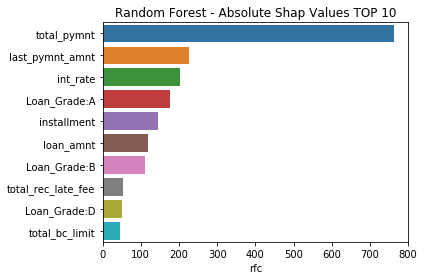

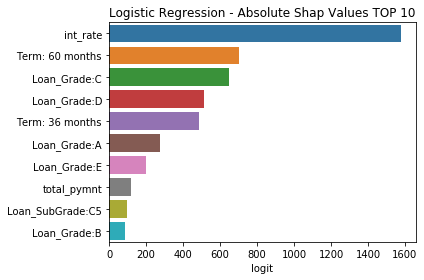

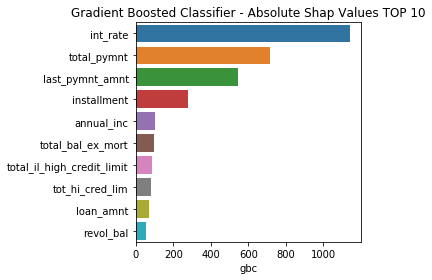

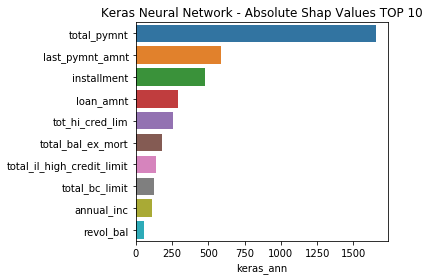

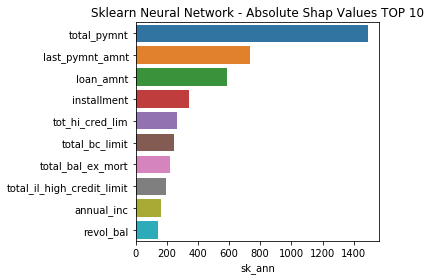

In [16]:
'''
Absolute and summation of shap values can be found @ obj/lendingclub/shap/ as csv files
The below will output the top ten ranked by absolute value, and the top and bottom 5 feats. by raw magnitude.
'''


display_abs_shapvalues(shapvalues=shap_values,
                       features=features,
                       num_features=10)


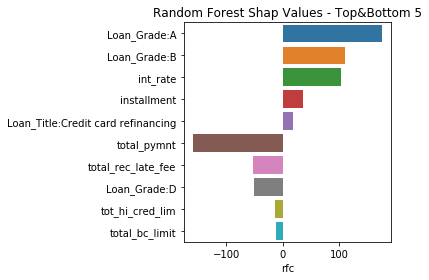

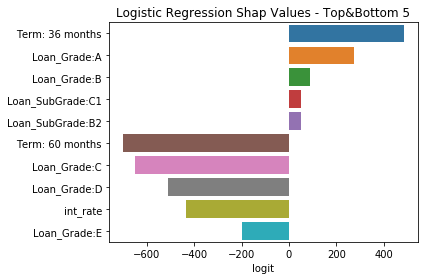

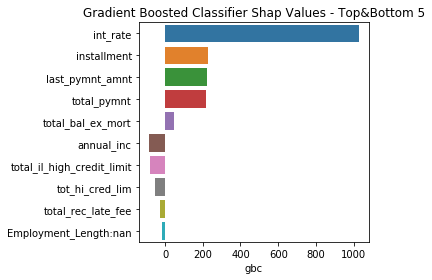

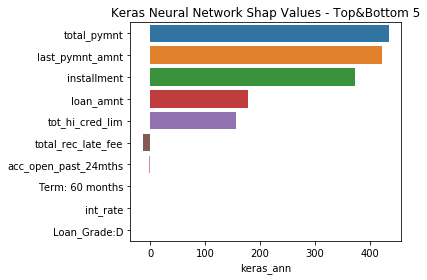

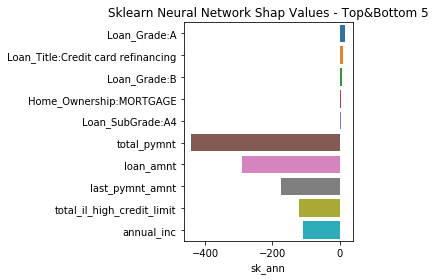

In [17]:
'''
For keras neural network below...
I believe we see the magnitudes in the negative direction lower here due to the low base value. Again,
Base value was computed as the probability of class 1 over the median of the columns in the train data.
This ended up being a predicted probability of ~6%. 
Because Shap is pred - baseline & our baseline is so low, it makes sense that there would be more push toward a more positive
model output - Atleast, that's what I'm thinking

'''

display_shapvalues(shapvalues=shap_values, features=features, n=10)


### Other Attributions Shapley/Saliency maps/Gradient * Input

In [18]:
# Show integrated gradients of only continuous features
rcParams['figure.figsize'] = 5, 5
keras_ig_df = load_obj('data_objects/keras_ig_df')
attributions_gradin = load_obj('attributions_gradin')
attributions_sal = load_obj('attributions_sal')
attributions_elrp = load_obj('attributions_elrp')

attribution_dict = {'grad_x_input': attributions_gradin, 'saliency maps': attributions_sal,
                    'layerwise relevance propogation': attributions_elrp, 'integrated gradients': keras_ig_df}


@interact
def shap_plot_summary_int(column=list(keras_ig_df[continuous].columns),
                          attributions=['grad_x_input', 'saliency maps', 'layerwise relevance propogation', 'integrated gradients']):
    try:
        deep_df = pd.DataFrame(
            attribution_dict[attributions], columns=features)
        return deep_df[column].iplot(
            kind='area',
            xTitle='Observation',
            yTitle='{} Grad Value'.format(attributions),
            title='{} Value vs Observation, Feature: {}'.format(attributions,
                                                                column))
    except:
        print("Plotly Needs to be installed and linked locally if you are receiving this error message")


interactive(children=(Dropdown(description='column', options=('loan_amnt', 'int_rate', 'installment', 'annual_…

In [19]:
# Removed dependency on DeepExplain.
# Can pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain


@interact
def display_gam_feat_importance(attributions=[
        'grad_x_input', 'saliency maps', 'layerwise relevance propogation', 'integrated gradients'
], save=button_widg):

    # Load attributions and show columnwise dotplots. Note that we are only looking at the tail 14 features here.
    deep_df = pd.DataFrame(attribution_dict[attributions], columns=features)
    deep_df = deep_df.iloc[:, -10:].melt(var_name='groups', value_name='vals')
    ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
    if 'saliency maps' in attributions:
        plt.xlim(0, 0.30)
    else:
        plt.xlim(-75, 75)
    plt.title('{} Attributions'.format(attributions))
    if save:
        path = 'images/Non_shap_attributions/{}.png'.format(attributions)
        plt.savefig(path)
        print("Image saved to {}".format(path))


interactive(children=(Dropdown(description='attributions', options=('grad_x_input', 'saliency maps', 'layerwis…

### GAM

#### GAM Attributions On Full Keras ANN Shap Values

In [20]:
# Gam Helpers


def shap_to_csv(model, file_name):
    local = pd.DataFrame(shap_values[str(type(model))],
                         columns=features)  # Sample 1000 rows of shap values
    local.to_csv('obj/lendingclub/gam/{}_local.csv'.format(file_name),
                 index=False)
    
def autolabel(rects):
    x_pos = [rect.get_x() + rect.get_width()/2. for rect in rects]
    y_pos = [rect.get_y() + 1.05*rect.get_height() for rect in rects]
    #if height constant: hbars, vbars otherwise
    if (np.diff([plt.getp(item, 'width') for item in rects])==0).all():
        scores = [plt.getp(item, 'height') for item in rects]
    else:
        scores = [plt.getp(item, 'width') for item in rects]
    # attach some text labels
    for rect, x, y, s in zip(rects, x_pos, y_pos, scores):
        ax.text(x, 
                y,
                '%s'%s,
                ha='center', va='bottom')

def display_gam(gam):
    for i in range(len(gam.explanations)):

        print('\t\t\t\tShowing GAM Explanation #{}'.format(i + 1))
        gam_nn_df = pd.DataFrame(gam.explanations[i],
                                 columns=['features',
                                          'Feature Importance']).sort_values(
                                              by='Feature Importance',
                                              ascending=False)
        gam_nn_df = gam_nn_df[gam_nn_df['Feature Importance'] > 0]
        gam_nn_df['Feature Importance'] = np.round(
            gam_nn_df['Feature Importance'], 2)
        gam_nn_df.sort_values('Feature Importance', inplace = True)
        # print(gam_nn_df.to_string())
        fig = plt.figure(figsize=(9, 9))
        ax = fig.add_subplot(121)
        ax.barh(gam_nn_df['features'], gam_nn_df['Feature Importance'])
        ax.set_xlabel('Feature Importance', fontsize=10)
        ax.set_ylabel('Feature', fontsize='large')  
        ax.set_title('GAM Neural Network Explanation #{}'.format(i + 1))
        for i, v in enumerate(gam_nn_df['Feature Importance'].values):
            ax.text(v -.01, i , str(v), color='red', fontweight='bold')
        plt.tight_layout(rect=[0.11, 0.1, 1.6, .95])
        plt.show()
        print('-' * 100)


def shap_to_csv_all_models(model, num_obs, k):
    file_name = models[str(type(model))][0]
    local = pd.DataFrame(shap_values[str(type(model))],
                         columns=features).iloc[:num_obs, :]
    local.to_csv('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs),
        index=False)
    gam_test = GAM(
        attributions_path='obj/lendingclub/gam/{}_{}obs_local.csv'.format(
            file_name, num_obs),
        k=k)
    gam_test.generate()
    os.remove('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs))
    return gam_test


def att_to_csv_all_attributions(df, num_obs, k):
    file_name = 'integrated_gradients'
    local = non_shap_attributions[df].iloc[:num_obs, :]
    local.to_csv('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs),
        index=False)
    gam_test = GAM(
        attributions_path='obj/lendingclub/gam/{}_{}obs_local.csv'.format(
            file_name, num_obs),
        k=k)
    gam_test.generate()
    os.remove('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs))
    return gam_test


				Showing GAM Explanation #1


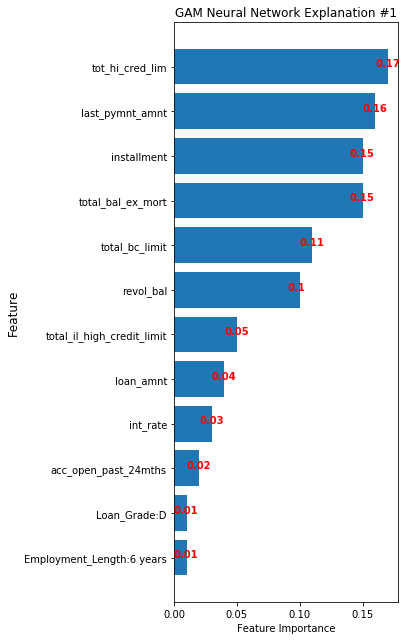

----------------------------------------------------------------------------------------------------
				Showing GAM Explanation #2


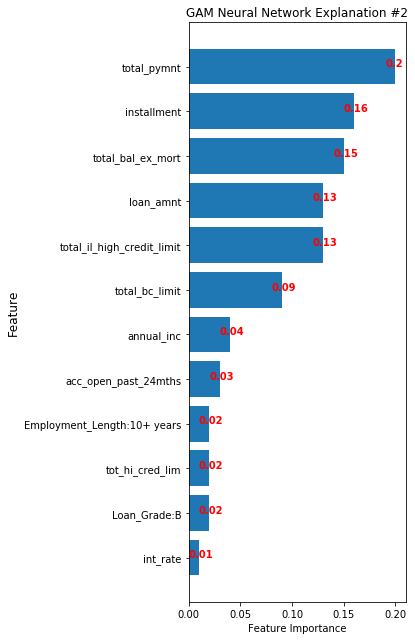

----------------------------------------------------------------------------------------------------


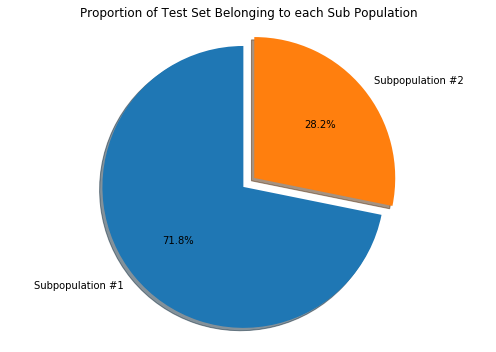

In [21]:
'''
Reload GAM objects + Plot all feature importance metrics for each of the explanations.
Plot shows: Top 2 Clusters and their top features

https://github.com/capitalone/global-attribution-mapping

Below is Gam Attribution on the whole entire test set's shap values w/ k = 2
'''

rcParams['figure.figsize'] = 7, 5  # Adjust plot size

gam_keras = load_obj('/gam/gam_keras')

display_gam(gam_keras)

labels = ['Subpopulation #1', 'Subpopulation #2']
sizes = [
    gam_keras.subpopulation_sizes[0] / sum(gam_keras.subpopulation_sizes) *
    100,
    gam_keras.subpopulation_sizes[1] / sum(gam_keras.subpopulation_sizes) * 100
]
explode = (0.1, 0.0)
fig1, ax1 = plt.subplots()

ax1.pie(sizes,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
ax1.axis('equal')
plt.title('Proportion of Test Set Belonging to each Sub Population')
plt.tight_layout(rect=[0.11, 0.1, 1.6, .95])
plt.show()


#### Plots for samples of shap values based on various models

In [22]:
'''
This works for model / gam generation selection, but is really computationally expensive when you try to generate
w/ more than 200 observations. I have it set up to randomly select n sets of shap values according to the slider.


'''


@interact
def display_gam_feat_importance(
        models=widgets.ToggleButtons(
            options=[
                'keras neural network', 'logistic regression',
                'gradient boosted trees', 'random forest'
            ],
            description='Models:',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltips=[
                'keras sequential neural network', 'sklearn logit',
                'sklearn gradient boosted classifier', 'sklearn random forest'
            ]),
        num_obs=list(range(25, 500, 25)),
        clusters=widgets.FloatText(value=2,
                                   description='# of clusters:',
                                   disabled=False), save=button_widg):
    gam = shap_to_csv_all_models(model=model_dict_2[models],
                                 num_obs=num_obs,
                                 k=clusters)
    display_gam(gam)
    


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

In [78]:
'''
Testing other attr. values
'''

gradin = pd.DataFrame(load_obj('attributions_gradin'), columns=features)
saliency = pd.DataFrame(load_obj('attributions_sal'), columns=features)
layerwise = pd.DataFrame(load_obj('attributions_elrp'), columns=features)

non_shap_attributions = {
    'grad * input': gradin,
    'saliency maps': saliency,
    'layerwise relevance propogation': layerwise,
    'integrated gradients': keras_ig_df
}

print("GAM - Non-Shap Attributions")


@interact
def display_gam_feat_importance(attributions=[
        'grad * input', 'saliency maps', 'layerwise relevance propogation',
        'integrated gradients'
],
        num_obs=list(range(25, 500, 25)),
        clusters=widgets.FloatText(
        value=2,
        description='# of clusters:',
        disabled=False)):

    gam = att_to_csv_all_attributions(df=attributions,
                                      num_obs=num_obs,
                                      k=clusters)
    display_gam(gam)


GAM - Non-Shap Attributions


interactive(children=(Dropdown(description='attributions', options=('grad * input', 'saliency maps', 'layerwis…

### Test where I manually break out into Subpopulations according to Class

In [88]:
def shap_to_csv_all_models_test(model, num_obs, Positive_class , k):
    if Positive_class:
        inds = np.where(y_test == 1)[0][:num_obs]
    else:
        inds = np.where(y_test == 0)[0][:num_obs]
    
    file_name = models[str(type(model))][0]
    local = pd.DataFrame(shap_values[str(type(model))],
                         columns=features).iloc[inds, :]
    local.to_csv('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs),
        index=False)
    gam_test = GAM(
        attributions_path='obj/lendingclub/gam/{}_{}obs_local.csv'.format(
            file_name, num_obs),
        k=k)
    gam_test.generate()
    os.remove('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs))
    return gam_test

def display_gam_test(gam, flag = 1):
    print('\t\t\t\tShowing GAM Explanation ')
    gam_nn_df = pd.DataFrame(gam.explanations[0],
                             columns=['features',
                                      'Feature Importance']).sort_values(
                                          by='Feature Importance',
                                          ascending=False)
    gam_nn_df = gam_nn_df[gam_nn_df['Feature Importance'] > 0]
    gam_nn_df['Feature Importance'] = np.round(
        gam_nn_df['Feature Importance'], 2)
    gam_nn_df.sort_values('Feature Importance', inplace = True)
    # print(gam_nn_df.to_string())
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(121)
    ax.barh(gam_nn_df['features'], gam_nn_df['Feature Importance'])
    ax.set_xlabel('Feature Importance', fontsize=10)
    ax.set_ylabel('Feature', fontsize='large')  
    if flag == 1:
        title = 'GOOD'
    else:
        title = "BAD"
    ax.set_title('GAM Neural Network Explanation : Class {} Loans'.format(title))
    for i, v in enumerate(gam_nn_df['Feature Importance'].values):
        ax.text(v -.01, i , str(v), color='red', fontweight='bold')
    plt.tight_layout(rect=[0.11, 0.1, 1.6, .95])
    plt.savefig('images/Explanation_{}'.format(title), eps = 1000, bbox_inches = "tight")
    plt.show()
    print('-' * 100)

    
@interact
def display_gam_feat_importance_test(
        models=widgets.ToggleButtons(
            options=[
                'keras neural network', 'logistic regression',
                'gradient boosted trees', 'random forest'
            ],
            description='Models:',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltips=[
                'keras sequential neural network', 'sklearn logit',
                'sklearn gradient boosted classifier', 'sklearn random forest'
            ]),
        num_obs=list(range(25, 2000, 25)),
        clusters=widgets.FloatText(value=1,
                                   description='# of clusters:',
                                   disabled=False), save=button_widg):
    gam = shap_to_csv_all_models_test(model=model_dict_2[models],
                                 num_obs=num_obs, Positive_class = True,
                                 k=clusters)
    display_gam_test(gam, flag = 1)    
    gam = shap_to_csv_all_models_test(model=model_dict_2[models],
                                 num_obs=num_obs, Positive_class = False,
                                 k=clusters)
    display_gam_test(gam, flag = 0) 
    


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…